In [1]:
cifar_dir = 'cifar-10-batches-py/'

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
all_data = list(range(7))

In [4]:
all_data


[0, 1, 2, 3, 4, 5, 6]

In [5]:
for i,directory in zip(all_data,dirs):
    all_data[i] = unpickle(cifar_dir+directory)

In [6]:
all_data[0].keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [7]:
batch_meta,data_batch_1,data_batch_2,data_batch_3,data_batch_4,data_batch_5,test_batch = all_data

In [8]:
batch_meta.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [9]:
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [10]:
type(batch_meta[b'label_names'])

list

In [11]:
batch_meta[b'label_names'][0]

b'airplane'

In [12]:
batch_meta[b'label_names'][6]

b'frog'

In [13]:
data_batch_1[b'labels'][0]

6

In [14]:
data_batch_1[b'data'][0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

In [15]:
data_batch_1[b'data'][0].shape

(3072,)

In [16]:
import matplotlib.pyplot as plt

In [17]:
X = data_batch_1[b'data']

In [18]:
X.shape

(10000, 3072)

In [19]:
X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype('uint8')

In [20]:
X.shape

(10000, 32, 32, 3)

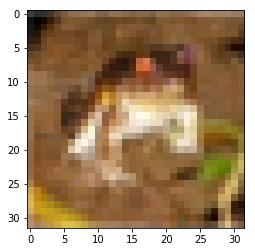

In [21]:
plt.imshow(X[0])

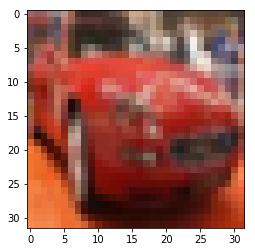

In [22]:
plt.imshow(X[5])

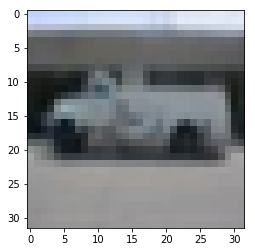

In [23]:
plt.imshow(X[110])

In [24]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [25]:
import numpy as np
def one_hot_encode(vector, values=10):
    n = len(vector)
    out = np.zeros((n,values))
    out[range(n),vector] = 1
    return out

In [26]:
class Cifar():
    def __init__(self):
        self.i = 0
        self.all_train_batches = [data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5]
        self.test_batch = [test_batch]
        self.training_images = None
        self.training_labels = None
        self.test_images = None
        self.test_labels = None
        
    def setUpImages(self):
        self.training_images = np.vstack([x[b'data'] for x in self.all_train_batches])
        train_len = len(self.training_images)
        self.training_images = self.training_images.reshape(train_len, 3, 32, 32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([x[b'labels'] for x in self.all_train_batches]), 10)
        print(train_len)
        print(self.training_images.shape)
        
        self.test_images = np.vstack([x[b'data'] for x in self.test_batch])
        test_len = len(self.test_images)
        self.test_images = self.test_images.reshape(test_len, 3, 32, 32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([x[b'labels'] for x in self.test_batch]), 10)
        print(test_len)
    
    def next_batch(self,batch_size):
        x = self.training_images[self.i : self.i + batch_size].reshape(batch_size,32,32,3)
        y = self.training_labels[self.i : self.i + batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x,y
        
        

In [27]:
ch = Cifar()

In [28]:
ch.setUpImages()

50000
(50000, 32, 32, 3)
10000


In [29]:
ch.next_batch(100)

(array([[[[0.23137255, 0.24313725, 0.24705882],
          [0.16862745, 0.18039216, 0.17647059],
          [0.19607843, 0.18823529, 0.16862745],
          ...,
          [0.61960784, 0.51764706, 0.42352941],
          [0.59607843, 0.49019608, 0.4       ],
          [0.58039216, 0.48627451, 0.40392157]],
 
         [[0.0627451 , 0.07843137, 0.07843137],
          [0.        , 0.        , 0.        ],
          [0.07058824, 0.03137255, 0.        ],
          ...,
          [0.48235294, 0.34509804, 0.21568627],
          [0.46666667, 0.3254902 , 0.19607843],
          [0.47843137, 0.34117647, 0.22352941]],
 
         [[0.09803922, 0.09411765, 0.08235294],
          [0.0627451 , 0.02745098, 0.        ],
          [0.19215686, 0.10588235, 0.03137255],
          ...,
          [0.4627451 , 0.32941176, 0.19607843],
          [0.47058824, 0.32941176, 0.19607843],
          [0.42745098, 0.28627451, 0.16470588]],
 
         ...,
 
         [[0.81568627, 0.66666667, 0.37647059],
          [0.78823

In [30]:
import tensorflow as tf

In [31]:
def init_weight(shape):
    initRandomWeights = tf.random_normal(shape, stddev = 0.1)
    return tf.Variable(initRandomWeights)

def init_bias(shape):
    bias = tf.constant(0.1, shape = shape)
    return tf.Variable(bias)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pooling(x):
#     ksize = size of window for each dimension of input tensor
#     1,h,w channel
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

def conv_layer(input_x,shape):
    W = init_weight(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,W)+b)

#  NN applied :
def fully_connected(input_layer,size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weight([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W) + b

In [32]:
x = tf.placeholder(tf.float32, shape=[None,32,32,3])
y = tf.placeholder(tf.float32, shape=[None,10])

In [33]:
conv_1 = conv_layer(x, shape=[4,4,3,32])
convMaxPooling = max_pooling(conv_1)

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
conv_2 = conv_layer(convMaxPooling, shape=[4,4,32,64])
convMaxPooling_2 = max_pooling(conv_2)

In [35]:
conv_flatten = tf.reshape(convMaxPooling_2,[-1,8*8*64])

In [36]:
full_layer = tf.nn.relu(fully_connected(conv_flatten,1024))

In [37]:
hold_prob = tf.placeholder(tf.float32)
full_dropout = tf.nn.dropout(full_layer, keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
y_pred = fully_connected(full_dropout,10)

In [39]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred))

In [40]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [41]:
init = tf.global_variables_initializer()

In [42]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1141


Currently on step 100
Accuracy is:
0.1865


Currently on step 200
Accuracy is:
0.2182


Currently on step 300
Accuracy is:
0.2331


Currently on step 400
Accuracy is:
0.2394


Currently on step 500
Accuracy is:
0.2524


Currently on step 600
Accuracy is:
0.2641


Currently on step 700
Accuracy is:
0.2677


Currently on step 800
Accuracy is:
0.2801


Currently on step 900
Accuracy is:
0.2765


Currently on step 1000
Accuracy is:
0.2904


Currently on step 1100
Accuracy is:
0.2943


Currently on step 1200
Accuracy is:
0.2989


Currently on step 1300
Accuracy is:
0.2979


Currently on step 1400
Accuracy is:
0.3062


Currently on step 1500
Accuracy is:
0.3097


Currently on step 1600
Accuracy is:
0.3098


Currently on step 1700
Accuracy is:
0.3137


Currently on step 1800
Accuracy is:
0.3171


Currently on step 1900
Accuracy is:
0.32


Currently on step 2000
Accuracy is:
0.3232


Currently on step 2100
Accuracy is:
0.3208


Currently on step 2200
A